In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#from bnn_shson_rhograd_170824 import *
from bnn_shson_171115 import *
import nbnn_shson_171116 as nb
import mbnn_shson_171116 as mb

import nn_shson
from shson_exp_manager import *
import h5py
import random

%matplotlib inline


In [2]:
def num_to_onehot(nums, n_labels):
    results = list()
    for i in range(len(nums)):
        res = np.zeros([n_labels])
        res[nums[i]] = 1
        results.append(res)
    return np.asarray(results, dtype = 'float32')
        

In [3]:
mnist = h5py.File('mnist.hdf5', 'r')

random.seed(1337)

perm1 = range(784)
perm2 = range(784)
perm3 = range(784)
perm4 = range(784)
perm5 = range(784)
perm6 = range(784)

random.shuffle(perm1)
random.shuffle(perm2)
random.shuffle(perm3)
random.shuffle(perm4)
random.shuffle(perm5)
random.shuffle(perm6)

print perm1[0:20]
print perm2[0:20]

x_train = list()
x_valid = list()
x_test = list()

x_train.append(mnist['train_data'][()])
x_train.append(mnist['train_data'][()][:, perm1])
x_train.append(mnist['train_data'][()][:, perm2])
x_train.append(mnist['train_data'][()][:, perm3])
x_train.append(mnist['train_data'][()][:, perm4])
x_train.append(mnist['train_data'][()][:, perm5])
x_train.append(mnist['train_data'][()][:, perm6])
t_train = num_to_onehot(mnist['train_label'][()], 10)
x_valid.append(mnist['valid_data'][()])
x_valid.append(mnist['valid_data'][()][:, perm1])
x_valid.append(mnist['valid_data'][()][:, perm2])
x_valid.append(mnist['valid_data'][()][:, perm3])
x_valid.append(mnist['valid_data'][()][:, perm4])
x_valid.append(mnist['valid_data'][()][:, perm5])
x_valid.append(mnist['valid_data'][()][:, perm6])
t_valid = num_to_onehot(mnist['valid_label'][()], 10)
x_test.append(mnist['test_data'][()])
x_test.append(mnist['test_data'][()][:, perm1])
x_test.append(mnist['test_data'][()][:, perm2])
x_test.append(mnist['test_data'][()][:, perm3])
x_test.append(mnist['test_data'][()][:, perm4])
x_test.append(mnist['test_data'][()][:, perm5])
x_test.append(mnist['test_data'][()][:, perm6])
t_test = num_to_onehot(mnist['test_label'][()], 10)

mnist.close()


[290, 476, 531, 412, 667, 470, 656, 123, 167, 378, 357, 729, 324, 327, 271, 681, 155, 75, 755, 316]
[398, 598, 337, 481, 192, 554, 297, 296, 157, 72, 29, 778, 513, 407, 264, 420, 69, 508, 690, 504]


In [4]:
batch_size = 200

In [5]:
def print_accs(accs, ep):
    res = ""
    for acc in accs:
        res += " {:.4f}".format(acc[ep])
    
    print res

# NBNN + SupGrad

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement = True, log_device_placement = True, gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nbnn = nb.nbnn_model([784, 400, 400, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 40, outact = tf.nn.relu, seed = 1234, \
                lr = 1e-5, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 400
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    nbnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nbnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nbnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = nbnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            nbnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = nbnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


#         if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
#             if patience == 0:
#                 last_lr = bnn.get_lr()
#                 bnn.decay_lr()
#                 patience = 3

#                 if bnn.get_lr() == last_lr:
#                     print("=== cannot decay more. stop learning this batch ===")
#                     break
#             else:
#                 patience -= 1


        if ep % 50 == 0: nbnn.print_ewcgrads(feed)
        #bnn.print_ewcgrads(feed)
        
        str_vacc = "data %d, ep %d, valid accuracy:"%(d, ep)
        for i in range(n_datas): 
            vaccs[i].append(nbnn.validate({nbnn.x: x_valid[i], nbnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={nbnn.x: x_valid[d], nbnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

        if ep > 40 and np.mean(vaccs[d][-40:-20]) > np.mean(vaccs[d][-20:]):
            last_lr = nbnn.get_lr()
            nbnn.decay_lr()

            if nbnn.get_lr() == last_lr:
                print("=== cannot decay more. stop learning this batch ===")
                break

    nbnn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_NBNN_MG = taccs
vaccs_NBNN_MG = vaccs

plt.title('NBNN with Modified Gradients')
plt.plot(taccs_NBNN_MG, 'k')
plt.plot(vaccs_NBNN_MG[0], 'b')
plt.plot(vaccs_NBNN_MG[1], 'g')
plt.plot(vaccs_NBNN_MG[2], 'r')
plt.plot(vaccs_NBNN_MG[3], 'c')
plt.plot(vaccs_NBNN_MG[4], 'b')
plt.plot(vaccs_NBNN_MG[5], 'g')
plt.plot(vaccs_NBNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# MBNN + SupGrad

In [ ]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement = True, log_device_placement = True, gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9)))


In [ ]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
mbnn = mb.mbnn_model([784, 400, 400, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 40, outact = tf.nn.relu, seed = 1234, \
                lr = 1e-5, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 400
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    mbnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {mbnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    mbnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = mbnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            mbnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = mbnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


#         if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
#             if patience == 0:
#                 last_lr = bnn.get_lr()
#                 bnn.decay_lr()
#                 patience = 3

#                 if bnn.get_lr() == last_lr:
#                     print("=== cannot decay more. stop learning this batch ===")
#                     break
#             else:
#                 patience -= 1


        if ep % 50 == 0: mbnn.print_ewcgrads(feed)
        #bnn.print_ewcgrads(feed)
        
        str_vacc = "data %d, ep %d, valid accuracy:"%(d, ep)
        for i in range(n_datas): 
            vaccs[i].append(mbnn.validate({mbnn.x: x_valid[i], mbnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={mbnn.x: x_valid[d], mbnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

        if ep > 40 and np.mean(vaccs[d][-40:-20]) > np.mean(vaccs[d][-20:]):
            last_lr = mbnn.get_lr()
            mbnn.decay_lr()

            if mbnn.get_lr() == last_lr:
                print("=== cannot decay more. stop learning this batch ===")
                break

    mbnn.update_prior()
    #bnn.print_params()




In [ ]:
taccs_MBNN_MG = taccs
vaccs_MBNN_MG = vaccs

plt.title('MBNN with Modified Gradients')
plt.plot(taccs_MBNN_MG, 'k')
plt.plot(vaccs_MBNN_MG[0], 'b')
plt.plot(vaccs_MBNN_MG[1], 'g')
plt.plot(vaccs_MBNN_MG[2], 'r')
plt.plot(vaccs_MBNN_MG[3], 'c')
plt.plot(vaccs_MBNN_MG[4], 'b')
plt.plot(vaccs_MBNN_MG[5], 'g')
plt.plot(vaccs_MBNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

# Online version + EWC with rho_grad

In [45]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement = True, log_device_placement = True, gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9)))


In [46]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
bnn = bnn_model([784, 400, 400, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, rhos = [-5.0, 1.0, 10.0], n_samples = 40, outact = tf.nn.relu, seed = 1234, \
                lr = 1e-5, kl_reweight = False, train_rho = True, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
layer done
(40, ?, 10)
[(<tf.Tensor 'gradients/AddN_10:0' shape=(785, 400) dtype=float32>, <tf.Variable 'layer0/q_pos/mu:0' shape=(785, 400) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_11:0' shape=(785, 400) dtype=float32>, <tf.Variable 'layer0/q_pos/rho:0' shape=(785, 400) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_5:0' shape=(401, 400) dtype=float32>, <tf.Variable 'layer1/q_pos/mu:0' shape=(401, 400) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_7:0' shape=(401, 400) dtype=float32>, <tf.Variable 'layer1/q_pos/rho:0' shape=(401, 400) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_6:0' shape=(401, 10) dtype=float32>, <tf.Variable 'layer2/q_pos/mu:0' shape=(401, 10) dtype=float32_ref>), (<tf.Tensor 'gradients/AddN_8:0' shape=(401, 10) dtype=float32>, <tf.Variable 'layer2/q_pos/rho:0' shape=(401, 10) dtype=float32_ref>)]


In [24]:
print bnn.p_params

[<tf.Variable 'layer0/p_pri/p_mu:0' shape=(785, 800) dtype=float32_ref>, <tf.Variable 'layer0/p_pri/p_rho:0' shape=(785, 800) dtype=float32_ref>, <tf.Variable 'layer1/p_pri/p_mu:0' shape=(801, 800) dtype=float32_ref>, <tf.Variable 'layer1/p_pri/p_rho:0' shape=(801, 800) dtype=float32_ref>, <tf.Variable 'layer2/p_pri/p_mu:0' shape=(801, 10) dtype=float32_ref>, <tf.Variable 'layer2/p_pri/p_rho:0' shape=(801, 10) dtype=float32_ref>]


In [ ]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 400
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    bnn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {bnn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    bnn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_q, v_p, v_l = bnn.get_fqpl(feed)
            fs.append(v_f), qs.append(v_q), ps.append(v_p), ls.append(v_l)

            bnn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = bnn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                print("f : {}, q : {}, p : {}, l : {}".format(v_f, v_q, v_p, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


#         if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
#             if patience == 0:
#                 last_lr = bnn.get_lr()
#                 bnn.decay_lr()
#                 patience = 3

#                 if bnn.get_lr() == last_lr:
#                     print("=== cannot decay more. stop learning this batch ===")
#                     break
#             else:
#                 patience -= 1


        if ep % 50 == 0: bnn.print_ewcgrads(feed)
        #bnn.print_ewcgrads(feed)
        
        str_vacc = "data %d, ep %d, valid accuracy:"%(d, ep)
        for i in range(n_datas): 
            vaccs[i].append(bnn.validate({bnn.x: x_valid[i], bnn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={bnn.x: x_valid[d], bnn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

        if ep > 40 and np.mean(vaccs[d][-40:-20]) > np.mean(vaccs[d][-20:]):
            last_lr = bnn.get_lr()
            bnn.decay_lr()

            if bnn.get_lr() == last_lr:
                print("=== cannot decay more. stop learning this batch ===")
                break

    bnn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.18
f : 2394636.25, q : 1714843.25, p : -661350.0, l : 18414.2402344
ep 0, batch 50, training accuracy 0.47
f : 2392462.0, q : 1714731.875, p : -661350.625, l : 16454.1328125
ep 0, batch 100, training accuracy 0.74
f : 2383241.25, q : 1714312.75, p : -661355.875, l : 7505.31933594
ep 0, batch 150, training accuracy 0.795
f : 2381078.75, q : 1714049.25, p : -661359.0, l : 5694.20605469
ep 0, batch 200, training accuracy 0.905
f : 2378341.0, q : 1713832.0, p : -661361.0, l : 2959.20825195
layer0/q_pos/mu:0
max: 270.433166504, min: -337.633270264, mean: 0.432666659355, std: 20.5667743683
layer0/q_pos/rho:0
max: -0.69931858778, min: -1.31960868835, mean: -0.996411144733, std: 0.0129201449454
layer1/q_pos/mu:0
max: 220.952148438, min: -197.558898926, mean: 0.0140353096649, std: 21.6803779602
layer1/q_pos/rho:0
max: -0.738734781742, min: -1.27839136124, mean: -0.996414721012, std: 0.0135070234537
layer2/q_pos/mu:0
max: 1366.60253906, min: -637.983276367, mea

In [ ]:
plt.plot(fs, 'r')
plt.plot(qs, 'b')
plt.plot(ps, 'g')
plt.plot(ls, 'k')

# plt.plot(fs[0:22], 'r')
# plt.plot(qs[0:22], 'b')
# plt.plot(ps[0:22], 'g')
# plt.plot(ls[0:22], 'k')

plt.legend(['f', 'q', 'p', 'l'])
plt.show()

In [ ]:
taccs_BNN_MG = taccs
vaccs_BNN_MG = vaccs

plt.title('Bayesian NN with Modified Gradients')
plt.plot(taccs_BNN_MG, 'k')
plt.plot(vaccs_BNN_MG[0], 'b')
plt.plot(vaccs_BNN_MG[1], 'g')
plt.plot(vaccs_BNN_MG[2], 'r')
plt.plot(vaccs_BNN_MG[3], 'c')
plt.plot(vaccs_BNN_MG[4], 'b')
plt.plot(vaccs_BNN_MG[5], 'g')
plt.plot(vaccs_BNN_MG[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [14]:
print_accs(vaccs_BNN_MG, 0)
print_accs(vaccs_BNN_MG, 199)
print_accs(vaccs_BNN_MG, 399)
print_accs(vaccs_BNN_MG, 599)
print_accs(vaccs_BNN_MG, 799)
print_accs(vaccs_BNN_MG, 999)
print_accs(vaccs_BNN_MG, 1199)
print_accs(vaccs_BNN_MG, 1399)

 0.9082 0.0979 0.0962 0.1078 0.0954 0.0924 0.1059
 0.9556 0.0951 0.0854 0.0947 0.0923 0.1501 0.1345
 0.9235 0.9003 0.0956 0.1205 0.0874 0.1105 0.0709
 0.9018 0.8957 0.9056 0.1202 0.0822 0.1405 0.0928
 0.8453 0.8583 0.8723 0.9017 0.0929 0.1504 0.0605
 0.7894 0.8008 0.8458 0.8628 0.8973 0.1109 0.0835
 0.7332 0.7940 0.8409 0.8684 0.8802 0.8733 0.0624
 0.6994 0.6958 0.7803 0.8108 0.8639 0.8504 0.8676


# Normal NN

In [33]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement = True, log_device_placement = True, gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9)))


In [34]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
nn = nn_shson.nn_model([784, 800, 800, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.sigmoid, seed = 1234, \
                lr = 1e-5, only_loglike = True, ewc = False)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
(?, 10)


In [35]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    nn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {nn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    nn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = nn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            nn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = nn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


        if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
            if patience == 0:
                last_lr = nn.get_lr()
                nn.decay_lr()
                patience = 3

                if nn.get_lr() == last_lr:
                    print("=== cannot decay more. stop learning this batch ===")
                    break
            else:
                patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(nn.validate({nn.x: x_valid[i], nn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={nn.x: x_valid[d], nn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))
        
        if ep > 10 and np.mean(vaccs[d][-10:-5]) > np.mean(vaccs[d][-5:]):
            last_lr = nn.get_lr()
            nn.decay_lr()

            if nn.get_lr() == last_lr:
                print("=== cannot decay more. stop learning this batch ===")
                break

    nn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.1
ep 0, batch 50, training accuracy 0.39
ep 0, batch 100, training accuracy 0.4
ep 0, batch 150, training accuracy 0.625
ep 0, batch 200, training accuracy 0.755
valid accuracy: 0.7971 0.1162 0.1474 0.095 0.0873 0.143 0.1103
valid accuracy: 0.8772 0.093 0.1342 0.0895 0.092 0.1334 0.1
valid accuracy: 0.9018 0.0906 0.1216 0.1005 0.093 0.1224 0.0985
valid accuracy: 0.9088 0.0911 0.1143 0.1072 0.0916 0.1206 0.0967
valid accuracy: 0.9162 0.0919 0.1076 0.1097 0.091 0.1185 0.095
valid accuracy: 0.9209 0.0931 0.1035 0.1107 0.0896 0.1193 0.0941
valid accuracy: 0.9252 0.0933 0.1021 0.1098 0.088 0.1189 0.0937
valid accuracy: 0.9284 0.0942 0.102 0.1112 0.0864 0.1183 0.0936
valid accuracy: 0.9316 0.0959 0.1008 0.1108 0.0853 0.1173 0.0934
valid accuracy: 0.9333 0.0977 0.0998 0.111 0.0851 0.1169 0.0931
valid accuracy: 0.9363 0.0975 0.1003 0.11 0.0857 0.1161 0.0921
valid accuracy: 0.9382 0.0985 0.1019 0.1105 0.0854 0.1163 0.0911
valid accuracy: 0.9406 0.1006 0.1018 0

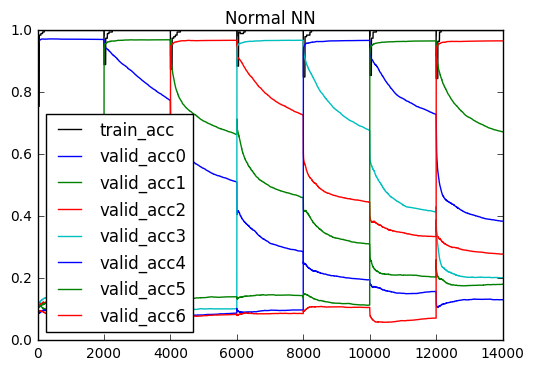

In [36]:
taccs_nNN = taccs
vaccs_nNN = vaccs

plt.title('Normal NN')

plt.plot(taccs_nNN, 'k')
plt.plot(vaccs_nNN[0], 'b')
plt.plot(vaccs_nNN[1], 'g')
plt.plot(vaccs_nNN[2], 'r')
plt.plot(vaccs_nNN[3], 'c')
plt.plot(vaccs_nNN[4], 'b')
plt.plot(vaccs_nNN[5], 'g')
plt.plot(vaccs_nNN[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [38]:
print_accs(vaccs_nNN, 0)
print_accs(vaccs_nNN, 1999)
print_accs(vaccs_nNN, 3999)
print_accs(vaccs_nNN, 5999)
print_accs(vaccs_nNN, 7999)
print_accs(vaccs_nNN, 9999)
print_accs(vaccs_nNN, 11999)
print_accs(vaccs_nNN, 13999)

 0.7971 0.1162 0.1474 0.0950 0.0873 0.1430 0.1103
 0.9709 0.0987 0.1294 0.1281 0.0854 0.1259 0.0839
 0.7743 0.9699 0.1293 0.1288 0.1072 0.1267 0.0894
 0.5113 0.6639 0.9682 0.1021 0.0882 0.1408 0.0840
 0.2869 0.4611 0.7268 0.9682 0.0983 0.1449 0.0867
 0.1955 0.3105 0.4466 0.6777 0.9679 0.1140 0.1067
 0.1584 0.2041 0.3351 0.4148 0.7299 0.9662 0.0721
 0.1314 0.1813 0.2786 0.2023 0.3849 0.6730 0.9663


# Normal NN + EWC

In [24]:
try:
    tf.reset_default_graph()
    sess.close()
except:
    pass
sess = tf.InteractiveSession(config=tf.ConfigProto(allow_soft_placement = True, log_device_placement = True, gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.9)))


In [25]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 800, 800, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.nn.relu, seed = 1234, \
                lr = 1e-5, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
layer done
(?, 10)


In [25]:
#bnn = bnn_model(shape, mu = 0.1, rho = 0.1, n_samples = 10, outact = tf.sigmoid, seed = 1234, lr = 1e-8)
enn = nn_shson.nn_model([784, 400, 400, 10], size_data = len(t_train), size_batch = batch_size, \
                mu = 0.02, outact = tf.nn.relu, seed = 1234, \
                lr = 1e-4, only_loglike = False, ewc = True)

merged = tf.summary.merge_all()

savedir = make_savedir("experiment_saves/")

train_writer = tf.summary.FileWriter(savedir + 'train', sess.graph)
test_writer = tf.summary.FileWriter(savedir + 'test')

layer done
layer done
layer done
(?, 10)


In [26]:
#sess.run(tf.initialize_all_variables())
tf.global_variables_initializer().run()

n_datas = 7

n_epochs = 2000
n_batches = len(t_train) / batch_size
patience = 3

fs = list()
qs = list()
ps = list()
ls = list()
fs_mean = list()
taccs = list()
taccs_mean = list()
vaccs = list()
for i in range(n_datas):
    vaccs.append(list())

for d in range(n_datas):
    enn.reset_lr()
    #fs_mean = list()
    for ep in range(n_epochs):

        for i in range(n_batches):

            feed = {enn.x: x_train[d][i*batch_size:(i+1)*batch_size], \
                    enn.t: t_train[i*batch_size:(i+1)*batch_size]}

            v_f, v_l = enn.get_fqpl(feed)
            fs.append(v_f), ls.append(v_l)

            enn.train(feed)

            if (i % 50 == 0) and (ep % 50 == 0):
                train_accuracy = enn.validate(feed)
                
                print("ep %d, batch %d, training accuracy %g"%(ep, i, train_accuracy))
                #print("f : {}, l : {}".format(v_f, v_l))

        fs_mean.append(np.mean(fs[-n_batches:]))


#         if ep > 5 and np.mean(fs_mean[-25:]) < fs_mean[-1]:
#             if patience == 0:
#                 last_lr = enn.get_lr()
#                 enn.decay_lr()
#                 patience = 3

#                 if enn.get_lr() == last_lr:
#                     print("=== cannot decay more. stop learning this batch ===")
#                     break
#             else:
#                 patience -= 1
        
        str_vacc = "valid accuracy:"        
        for i in range(n_datas): 
            vaccs[i].append(enn.validate({enn.x: x_valid[i], enn.t: t_valid}))
            str_vacc += " {:.5g}".format(vaccs[i][-1])
        
        taccs.append(train_accuracy)
        print(str_vacc)

        summary = sess.run(merged, feed_dict ={enn.x: x_valid[d], enn.t: t_valid})
        test_writer.add_summary(summary, (d+1)*(ep+1))

        if ep > 40 and np.mean(vaccs[d][-40:-20]) > np.mean(vaccs[d][-20:]):
            last_lr = enn.get_lr()
            enn.decay_lr()

            if enn.get_lr() == last_lr:
                print("=== cannot decay more. stop learning this batch ===")
                break

    enn.update_prior()
    #bnn.print_params()




ep 0, batch 0, training accuracy 0.135
ep 0, batch 50, training accuracy 0.155
ep 0, batch 100, training accuracy 0.175
ep 0, batch 150, training accuracy 0.135
ep 0, batch 200, training accuracy 0.265
valid accuracy: 0.2828 0.0684 0.0937 0.0786 0.0683 0.0996 0.0937
valid accuracy: 0.4083 0.0924 0.1012 0.1078 0.0855 0.0989 0.0996
valid accuracy: 0.5298 0.101 0.1053 0.1169 0.0955 0.1007 0.1014
valid accuracy: 0.5732 0.1011 0.1064 0.1145 0.0987 0.1004 0.1007
valid accuracy: 0.5905 0.1007 0.1064 0.1091 0.0994 0.0992 0.1003
valid accuracy: 0.5985 0.1009 0.1053 0.104 0.0987 0.099 0.0998
valid accuracy: 0.6031 0.1008 0.1054 0.1028 0.0985 0.099 0.0998
valid accuracy: 0.6101 0.1 0.1059 0.1012 0.0984 0.099 0.0998
valid accuracy: 0.62 0.099 0.1077 0.1013 0.0968 0.0991 0.1004
valid accuracy: 0.6406 0.0979 0.1137 0.1017 0.0955 0.0992 0.104
valid accuracy: 0.6673 0.0959 0.1255 0.1038 0.0884 0.1008 0.1144
valid accuracy: 0.6917 0.0961 0.1396 0.1072 0.0763 0.1049 0.1326
valid accuracy: 0.7096 0.1002 

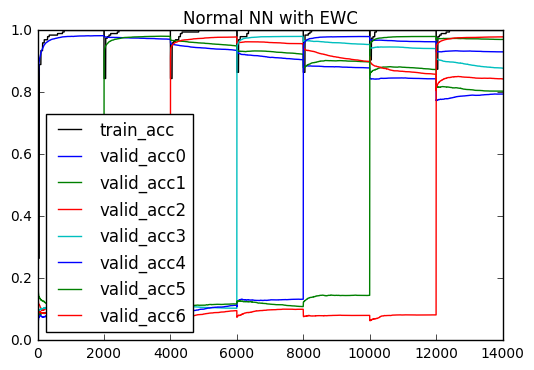

In [27]:
taccs_NNEWC = taccs
vaccs_NNEWC = vaccs

plt.title('Normal NN with EWC')
plt.plot(taccs_NNEWC, 'k')
plt.plot(vaccs_NNEWC[0], 'b')
plt.plot(vaccs_NNEWC[1], 'g')
plt.plot(vaccs_NNEWC[2], 'r')
plt.plot(vaccs_NNEWC[3], 'c')
plt.plot(vaccs_NNEWC[4], 'b')
plt.plot(vaccs_NNEWC[5], 'g')
plt.plot(vaccs_NNEWC[6], 'r')

plt.legend(['train_acc', 'valid_acc0', 'valid_acc1', 'valid_acc2', 'valid_acc3', 'valid_acc4', 'valid_acc5', 'valid_acc6'],loc = 3)
plt.show()

In [28]:
print_accs(vaccs_NNEWC, 0)
print_accs(vaccs_NNEWC, 1999)
print_accs(vaccs_NNEWC, 3999)
print_accs(vaccs_NNEWC, 5999)
print_accs(vaccs_NNEWC, 7999)
print_accs(vaccs_NNEWC, 9999)
print_accs(vaccs_NNEWC, 11999)
print_accs(vaccs_NNEWC, 13999)

 0.2828 0.0684 0.0937 0.0786 0.0683 0.0996 0.0937
 0.9831 0.0754 0.1414 0.1317 0.1210 0.1228 0.0720
 0.9714 0.9810 0.1291 0.1200 0.1134 0.1185 0.0656
 0.9356 0.9504 0.9790 0.1037 0.1132 0.1179 0.0961
 0.9056 0.9235 0.9570 0.9807 0.1330 0.1092 0.1006
 0.8791 0.8984 0.8996 0.9547 0.9803 0.1455 0.0808
 0.8440 0.8741 0.8586 0.9414 0.9635 0.9805 0.0824
 0.7948 0.8041 0.8437 0.8784 0.9309 0.9710 0.9793
